# Mitotic Figure Binary Classification – Vision Transformer (ViT-B16) Full Model

This notebook trains a Vision Transformer (ViT-B16) model for binary classification of mitotic figures (Normal vs Atypical) using a pre-augmented, pre-split dataset.

## Key Components
- Backbone: ViT-B16 (ImageNet pretrained, all parameters trainable)
- Input Resolution: 224 × 224
- Patch Size: 16 × 16
- Custom Classification Head: 768 → 512 → 256 → 128 → 2 (Softmax output)
- Loss Function: Focal Loss (adaptive to class imbalance)
- Sampling Strategy: WeightedRandomSampler for balanced mini-batches
- Optimizer: Adam (full model), initial LR = 1e-4
- Scheduler: ReduceLROnPlateau (monitors validation loss)
- Early Stopping: Validation loss with patience = 10
- Metrics: Accuracy, Precision, Recall, F1-score, AUC, Confusion Matrix (raw & normalized), ROC Curve
- Artifacts: Best model checkpoint (by validation loss), final model checkpoint, JSON training summary

## Dataset Expectations
The dataset directory should contain `training/`, `validation/`, and `testing/` subfolders plus a CSV file with at least:
- `filename`
- `split` (training / validation / testing)
- `is_atypical` (boolean or 0/1)
- Optional: `is_augmented`, `augmentation_type`, `dataset`

## Workflow Outline
1. Load metadata and verify file existence
2. Compute class distribution and focal loss alpha
3. Build dataset and dataloaders with augmentation (lightweight — dataset already augmented)
4. Initialize ViT backbone + custom head (full model trainable)
5. Train with Focal Loss + sampler until early stopping
6. Evaluate on test set with detailed reporting
7. Save model weights and JSON summary

Proceed below to run all steps sequentially.

In [13]:
# # Install PyTorch and required packages
# import sys
# print(f"Python version: {sys.version}")

# # Update pip first
# ! python -m pip install --upgrade pip

# # Install PyTorch (CPU version for compatibility, change to CUDA if needed)
# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# # Install other required packages
# ! pip install opencv-python pillow scikit-learn seaborn matplotlib pandas numpy albumentations timm tqdm

# # Verify installation
# try:
#     import torch
#     print(f"PyTorch successfully installed: {torch.__version__}")
#     print(f"CUDA Available: {torch.cuda.is_available()}")
#     if torch.cuda.is_available():
#         print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
# except ImportError as e:
#     print(f"PyTorch installation failed: {e}")

In [14]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import torchvision.models as models

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB


In [ ]:
# Set random seeds for reproducibility
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Define paths for your Kaggle dataset structure
BASE_DIR = Path('/kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset')
TRAINING_DIR = BASE_DIR / 'training'
VALIDATION_DIR = BASE_DIR / 'validation'
TESTING_DIR = BASE_DIR / 'testing'
DATASET_CSV = BASE_DIR / 'mitotic_figures_dataset.csv'

print(f"📁 Dataset paths for your pre-split Kaggle dataset:")
print(f"Base directory: {BASE_DIR}")
print(f"Training images: {TRAINING_DIR}")
print(f"Validation images: {VALIDATION_DIR}")
print(f"Testing images: {TESTING_DIR}")
print(f"Dataset CSV: {DATASET_CSV}")

# Check if directories exist
for dir_path, name in [(TRAINING_DIR, 'Training'), (VALIDATION_DIR, 'Validation'), (TESTING_DIR, 'Testing')]:
    if dir_path.exists():
        print(f"✅ {name} directory found")
    else:
        print(f"❌ {name} directory not found: {dir_path}")

# Training parameters (Aligned with ConvNeXt notebook for parity)
IMG_SIZE = 224           # Standard input size for ViT-B16 (224x224)
BATCH_SIZE = 32          # Same as ConvNeXt
EPOCHS = 250             # Parity with ConvNeXt assignment setting
LEARNING_RATE = 1e-4     # Full model training LR
NUM_CLASSES = 2
PATIENCE = 10            # Early stopping patience (validation loss)

print(f"🎯 VISION TRANSFORMER ViT-B16 FULL MODEL PARAMETERS:")
print(f"Model: Vision Transformer ViT-B16 (Full model training)")
print(f"Backbone: ViT-B16 (trainable)")
print(f"Output: 2 neurons with SoftMax activation")
print(f"Loss function: Will use FocalLoss()")
print(f"Dataset directory: {BASE_DIR}")
print(f"Dataset CSV: {DATASET_CSV}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE} (full model)")
print(f"Training approach: FULL MODEL training (entire network)")
print(f"Early stopping patience: {PATIENCE}")
print(f"Using GPU: {torch.cuda.is_available()}")
print(f"Automatic pretrained weights: ✅ (ImageNet ViT-B16)")

📁 Dataset paths for your pre-split Kaggle dataset:
Base directory: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset
Training images: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/training
Validation images: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/validation
Testing images: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/testing
Dataset CSV: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/mitotic_figures_dataset.csv
✅ Training directory found
✅ Validation directory found
✅ Testing directory found
🎯 VISION TRANSFORMER ViT-B16 GAP PARAMETERS:
Model: Vision Transformer ViT-B16 + Global Average Pooling
Dataset directory: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset
Dataset CSV: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/mitoti

## Loading Pre-Augmented Dataset

In [16]:
# Load the organized dataset from your Kaggle upload
print("Loading pre-split dataset from Kaggle...")

# Load the CSV with all metadata
df = pd.read_csv(DATASET_CSV)
print(f"Dataset loaded: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display dataset information
print(f"\nDataset Statistics:")
print(f"Total samples: {len(df)}")

# Check split distribution
if 'split' in df.columns:
    split_counts = df['split'].value_counts()
    print(f"\nSplit distribution:")
    for split in ['training', 'validation', 'testing']:
        count = split_counts.get(split, 0)
        percentage = (count / len(df)) * 100 if len(df) > 0 else 0
        print(f"  {split.capitalize()}: {count} samples ({percentage:.1f}%)")
else:
    print("⚠️ No split column found - dataset might not be properly split")

# Check class distribution
class_counts = df['is_atypical'].value_counts()
print(f"\nClass distribution:")
print(f"Normal (False): {class_counts.get(False, 0)}")
print(f"Atypical (True): {class_counts.get(True, 0)}")

# Check augmentation status
if 'is_augmented' in df.columns:
    aug_counts = df['is_augmented'].value_counts()
    print(f"\nAugmentation breakdown:")
    print(f"Original: {aug_counts.get(False, 0)}")
    print(f"Augmented: {aug_counts.get(True, 0)}")

# Check augmentation types
if 'augmentation_type' in df.columns:
    aug_types = df['augmentation_type'].value_counts()
    print(f"\nAugmentation types:")
    for aug_type, count in aug_types.items():
        print(f"  {aug_type}: {count}")

# Check dataset sources
if 'dataset' in df.columns:
    dataset_counts = df['dataset'].value_counts()
    print(f"\nDataset sources:")
    for dataset, count in dataset_counts.items():
        print(f"  {dataset}: {count}")

# Show first few rows
print(f"\nFirst 5 rows:")
print(df[['filename', 'is_atypical', 'split', 'is_augmented']].head())

print(f"\n✅ Dataset loaded successfully!")

Loading pre-split dataset from Kaggle...
Dataset loaded: (19162, 6)
Columns: ['filename', 'is_atypical', 'dataset', 'split', 'is_augmented', 'augmentation_type']

Dataset Statistics:
Total samples: 19162

Split distribution:
  Training: 13586 samples (70.9%)
  Validation: 2788 samples (14.5%)
  Testing: 2788 samples (14.5%)

Class distribution:
Normal (False): 11762
Atypical (True): 7400

Augmentation breakdown:
Original: 13938
Augmented: 5224

Augmentation types:
  1.0: 1306
  2.0: 1306
  3.0: 1306
  4.0: 1306

Dataset sources:
  MIDOG25: 16151
  AMI-BR: 3011

First 5 rows:
           filename  is_atypical     split  is_augmented
0          1371.png        False  training         False
1  TUPAC16_2232.png        False  training         False
2          3733.png         True  training         False
3          9796.png        False  training         False
4          5477.png        False  training         False

✅ Dataset loaded successfully!


In [17]:
# Prepare the dataset for training using pre-split structure
print("Preparing pre-split dataset for training...")

# Create image paths based on the split information
def get_image_path(row):
    """Get the full image path based on split folder"""
    split_folder = row['split']
    filename = row['filename']
    
    if split_folder == 'training':
        return str(TRAINING_DIR / filename)
    elif split_folder == 'validation':
        return str(VALIDATION_DIR / filename)
    elif split_folder == 'testing':
        return str(TESTING_DIR / filename)
    else:
        # Fallback - try to find the file in any folder
        for folder in [TRAINING_DIR, VALIDATION_DIR, TESTING_DIR]:
            path = folder / filename
            if path.exists():
                return str(path)
        return str(TRAINING_DIR / filename)  # Default fallback

# Add image paths
df['image_path'] = df.apply(get_image_path, axis=1)

# Convert boolean to integer labels (0=Normal, 1=Atypical)
df['label'] = df['is_atypical'].astype(int)

# Verify file existence and filter out missing files
print("Verifying all image files exist...")
existing_files = []
missing_files = []

for idx, row in df.iterrows():
    if Path(row['image_path']).exists():
        existing_files.append(idx)
    else:
        missing_files.append(row['filename'])

if missing_files:
    print(f"⚠️ Warning: {len(missing_files)} files not found")
    if len(missing_files) <= 10:
        print(f"Missing files: {missing_files}")
    else:
        print(f"First 10 missing files: {missing_files[:10]}")

# Keep only existing files
df = df.loc[existing_files].reset_index(drop=True)

print(f"\nFinal dataset info:")
print(f"Total samples: {len(df)}")
print(f"Samples with existing files: {len(existing_files)}")
print(f"Missing files: {len(missing_files)}")

# Display augmentation breakdown if available
if 'is_augmented' in df.columns:
    aug_breakdown = df['is_augmented'].value_counts()
    print(f"\nAugmentation breakdown:")
    print(f"  Original images: {aug_breakdown.get(False, 0)}")
    print(f"  Augmented images: {aug_breakdown.get(True, 0)}")

# Display final class distribution
print(f"\nFinal class distribution:")
class_dist = df['label'].value_counts()
print(f"  Normal (0): {class_dist.get(0, 0)}")
print(f"  Atypical (1): {class_dist.get(1, 0)}")

# Display split distribution
print(f"\nSplit distribution:")
split_dist = df['split'].value_counts()
for split_name, count in split_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {split_name}: {count} samples ({percentage:.1f}%)")

print(f"\nSample data:")
print(df[['filename', 'label', 'is_atypical', 'split', 'is_augmented']].head())

Preparing pre-split dataset for training...
Verifying all image files exist...

Final dataset info:
Total samples: 19162
Samples with existing files: 19162
Missing files: 0

Augmentation breakdown:
  Original images: 13938
  Augmented images: 5224

Final class distribution:
  Normal (0): 11762
  Atypical (1): 7400

Split distribution:
  training: 13586 samples (70.9%)
  validation: 2788 samples (14.5%)
  testing: 2788 samples (14.5%)

Sample data:
           filename  label  is_atypical     split  is_augmented
0          1371.png      0        False  training         False
1  TUPAC16_2232.png      0        False  training         False
2          3733.png      1         True  training         False
3          9796.png      0        False  training         False
4          5477.png      0        False  training         False


## Data Visualization and Analysis

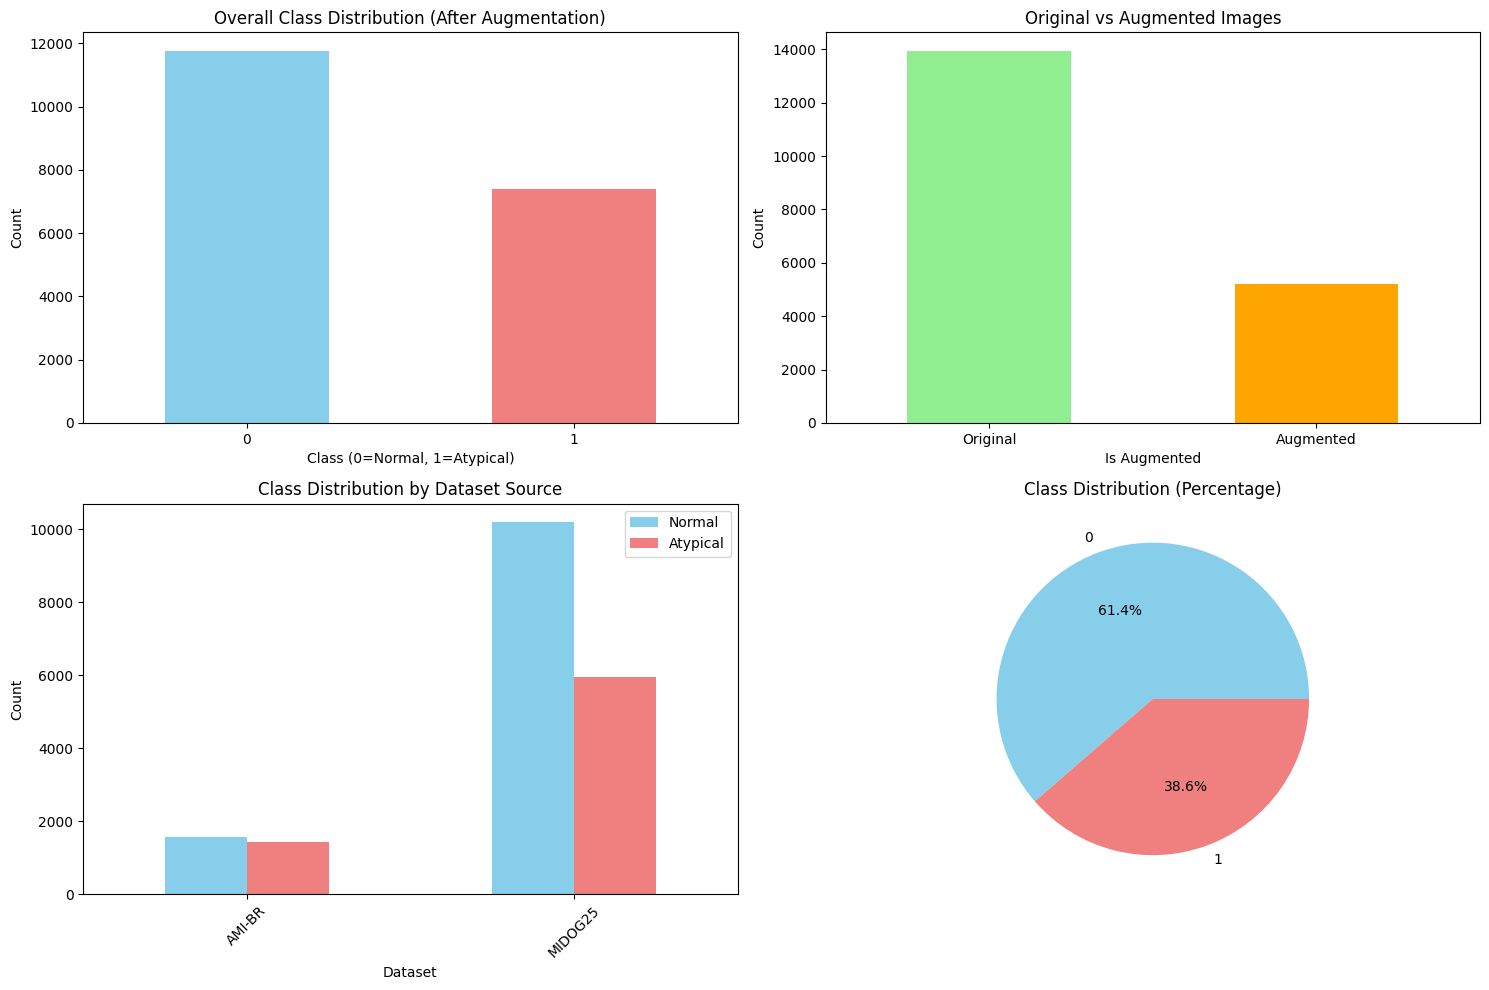

Detailed Statistics:
Total samples: 19162
Normal samples: 11762 (61.4%)
Atypical samples: 7400 (38.6%)

Augmentation breakdown:
Original images: 13938
Augmented images: 5224

By dataset source:
label        0     1    All
dataset                    
AMI-BR    1571  1440   3011
MIDOG25  10191  5960  16151
All      11762  7400  19162

Sample filenames:
['1371.png', 'TUPAC16_2232.png', '3733.png', '9796.png', '5477.png', '11425.png', '1203.png', '7546.png', 'TUPAC16_2410.png', '7783.png']


In [18]:
# Visualize class distribution of pre-augmented dataset
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall class distribution
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Overall Class Distribution (After Augmentation)')
axes[0,0].set_xlabel('Class (0=Normal, 1=Atypical)')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# Original vs Augmented distribution (if available)
if 'is_augmented' in df.columns:
    df['is_augmented'].value_counts().plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'orange'])
    axes[0,1].set_title('Original vs Augmented Images')
    axes[0,1].set_xlabel('Is Augmented')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_xticklabels(['Original', 'Augmented'], rotation=0)
else:
    axes[0,1].text(0.5, 0.5, 'Augmentation info\nnot available', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Original vs Augmented Images')

# Dataset source distribution (if available)
if 'dataset' in df.columns and len(df['dataset'].unique()) > 1:
    pd.crosstab(df['dataset'], df['label']).plot(kind='bar', ax=axes[1,0], 
                                                              color=['skyblue', 'lightcoral'])
    axes[1,0].set_title('Class Distribution by Dataset Source')
    axes[1,0].set_xlabel('Dataset')
    axes[1,0].set_ylabel('Count')
    axes[1,0].legend(['Normal', 'Atypical'])
    axes[1,0].tick_params(axis='x', rotation=45)
else:
    axes[1,0].text(0.5, 0.5, 'Dataset source info\nnot available', ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Class Distribution by Dataset Source')

# Percentage distribution
class_pct = df['label'].value_counts(normalize=True) * 100
class_pct.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
axes[1,1].set_title('Class Distribution (Percentage)')
axes[1,1].set_ylabel('')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Detailed Statistics:")
print(f"Total samples: {len(df)}")
print(f"Normal samples: {len(df[df['label'] == 0])} ({len(df[df['label'] == 0])/len(df)*100:.1f}%)")
print(f"Atypical samples: {len(df[df['label'] == 1])} ({len(df[df['label'] == 1])/len(df)*100:.1f}%)")

if 'is_augmented' in df.columns:
    print(f"\nAugmentation breakdown:")
    print(f"Original images: {len(df[df['is_augmented'] == False])}")
    print(f"Augmented images: {len(df[df['is_augmented'] == True])}")

if 'dataset' in df.columns:
    print(f"\nBy dataset source:")
    if len(df['dataset'].unique()) > 1:
        print(pd.crosstab(df['dataset'], df['label'], margins=True))
    else:
        print(f"Single dataset source: {df['dataset'].iloc[0]}")

# Show file naming patterns
print(f"\nSample filenames:")
print(df['filename'].head(10).tolist())

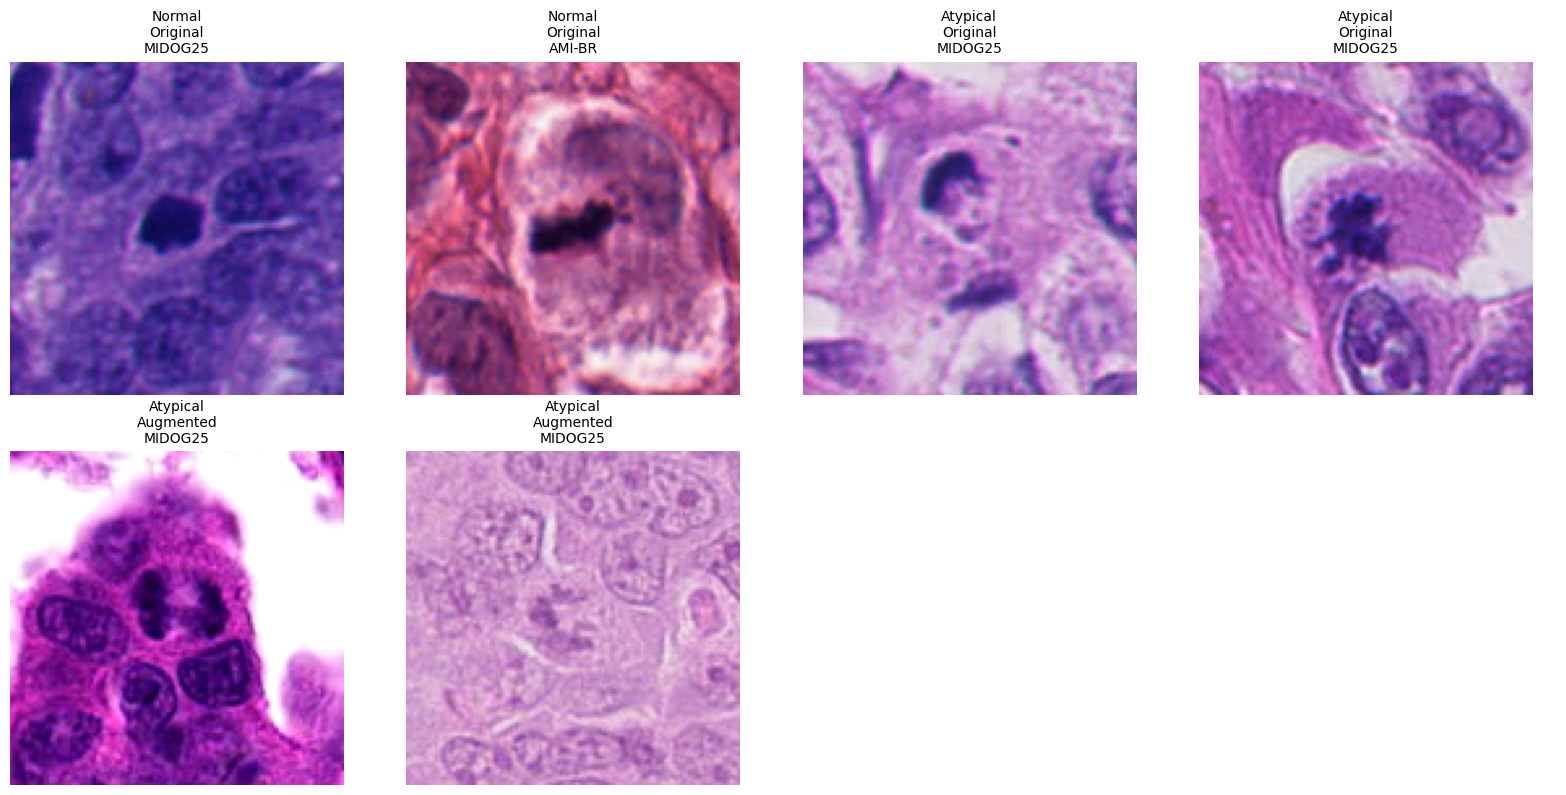

In [19]:
# Sample image visualization
def visualize_samples(df, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Get samples from each class
    samples = []
    
    # Get normal and atypical samples
    for label in [0, 1]:
        subset = df[df['label'] == label]
        if len(subset) > 0:
            # Try to get mix of original and augmented if available
            if 'is_augmented' in df.columns:
                original_subset = subset[subset['is_augmented'] == False]
                augmented_subset = subset[subset['is_augmented'] == True]
                
                # Get 2 original and 2 augmented if possible
                if len(original_subset) > 0:
                    samples.extend(original_subset.sample(min(2, len(original_subset))).to_dict('records'))
                if len(augmented_subset) > 0:
                    samples.extend(augmented_subset.sample(min(2, len(augmented_subset))).to_dict('records'))
            else:
                # Just get 4 samples of this class
                samples.extend(subset.sample(min(4, len(subset))).to_dict('records'))
    
    for i, sample in enumerate(samples[:8]):
        try:
            img = Image.open(sample['image_path'])
            axes[i].imshow(img)
            
            # Create title with available information
            label_text = 'Atypical' if sample['label'] == 1 else 'Normal'
            title_parts = [label_text]
            
            if 'is_augmented' in sample:
                aug_text = 'Augmented' if sample['is_augmented'] else 'Original'
                title_parts.append(aug_text)
            
            if 'dataset' in sample and sample['dataset'] != 'mixed':
                title_parts.append(sample['dataset'])
            
            title = '\n'.join(title_parts)
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{sample['filename']}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"Error: {sample['filename'][:20]}...")
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(samples), 8):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(df)

## Data Preparation for Training

In [20]:
# Use the pre-split data from your dataset
print("📊 Using pre-split dataset structure...")

# Extract splits based on the 'split' column
train_df = df[df['split'] == 'training'].reset_index(drop=True)
val_df = df[df['split'] == 'validation'].reset_index(drop=True)
test_df = df[df['split'] == 'testing'].reset_index(drop=True)

print(f"📈 Pre-split dataset distribution:")
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"Total: {len(train_df) + len(val_df) + len(test_df)} samples")

# Calculate percentages
total_samples = len(df)
train_pct = len(train_df) / total_samples * 100
val_pct = len(val_df) / total_samples * 100
test_pct = len(test_df) / total_samples * 100

print(f"\n📊 Split percentages:")
print(f"Training: {train_pct:.1f}%")
print(f"Validation: {val_pct:.1f}%")
print(f"Test: {test_pct:.1f}%")

# Check detailed class distribution in each set
print("\n🎯 Class distribution verification:")
for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    if len(split_df) > 0:
        class_dist = split_df['label'].value_counts()
        class_pct = split_df['label'].value_counts(normalize=True) * 100
        normal_count = class_dist.get(0, 0)
        atypical_count = class_dist.get(1, 0)
        normal_pct = class_pct.get(0, 0)
        atypical_pct = class_pct.get(1, 0)
        print(f"{split_name}: Normal={normal_count} ({normal_pct:.1f}%), "
              f"Atypical={atypical_count} ({atypical_pct:.1f}%)")

# Check augmentation distribution in each split
if 'is_augmented' in df.columns:
    print("\n🔄 Augmentation distribution by split:")
    for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        if len(split_df) > 0:
            aug_dist = split_df['is_augmented'].value_counts()
            original = aug_dist.get(False, 0)
            augmented = aug_dist.get(True, 0)
            print(f"{split_name}: Original={original}, Augmented={augmented}")

# Verify that we have samples in all splits
if len(train_df) == 0:
    raise ValueError("❌ No training samples found! Check your dataset split column values.")
if len(val_df) == 0:
    raise ValueError("❌ No validation samples found! Check your dataset split column values.")
if len(test_df) == 0:
    raise ValueError("❌ No test samples found! Check your dataset split column values.")

print(f"\n✅ Successfully loaded pre-split dataset!")
print(f"Ready for training with {len(train_df)} training samples")

📊 Using pre-split dataset structure...
📈 Pre-split dataset distribution:
Training set: 13586 samples
Validation set: 2788 samples
Test set: 2788 samples
Total: 19162 samples

📊 Split percentages:
Training: 70.9%
Validation: 14.5%
Test: 14.5%

🎯 Class distribution verification:
Train: Normal=7056 (51.9%), Atypical=6530 (48.1%)
Val: Normal=2353 (84.4%), Atypical=435 (15.6%)
Test: Normal=2353 (84.4%), Atypical=435 (15.6%)

🔄 Augmentation distribution by split:
Train: Original=8362, Augmented=5224
Val: Original=2788, Augmented=0
Test: Original=2788, Augmented=0

✅ Successfully loaded pre-split dataset!
Ready for training with 13586 training samples


In [21]:
# Define PyTorch Dataset class
class MitosisDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Load image
        try:
            image = cv2.imread(row['image_path'])
            if image is None:
                raise ValueError(f"Could not load image: {row['image_path']}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading {row['image_path']}: {e}")
            # Return a black image as fallback
            image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        
        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        label = torch.tensor(row['label'], dtype=torch.long)
        
        return image, label

# Define transforms (reduced augmentation since data is pre-augmented)
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.3),  # Reduced probability since data is pre-augmented
    A.Rotate(limit=15, p=0.3),  # Lighter augmentation
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create datasets
train_dataset = MitosisDataset(train_df, transform=train_transform)
val_dataset = MitosisDataset(val_df, transform=val_transform)
test_dataset = MitosisDataset(test_df, transform=val_transform)

# Calculate class weights for WeightedRandomSampler
print("📊 Calculating sample weights for balanced training...")
class_counts = train_df['label'].value_counts().sort_index()
total_samples = len(train_df)

print(f"Training set class distribution:")
for i, count in enumerate(class_counts):
    class_name = "Normal" if i == 0 else "Atypical"
    percentage = (count / total_samples) * 100
    print(f"  Class {i} ({class_name}): {count} samples ({percentage:.1f}%)")

# Calculate weights for each class (inverse of frequency)
class_weights = []
for i in range(len(class_counts)):
    weight = total_samples / (len(class_counts) * class_counts[i])
    class_weights.append(weight)
    class_name = "Normal" if i == 0 else "Atypical"
    print(f"  Class {i} ({class_name}) weight: {weight:.4f}")

# Create sample weights for each training sample
sample_weights = []
for _, row in train_df.iterrows():
    label = row['label']
    sample_weights.append(class_weights[label])

sample_weights = torch.DoubleTensor(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Allow replacement to balance classes
)

print(f"\n🎯 WeightedRandomSampler created:")
print(f"  Total samples: {len(sample_weights)}")
print(f"  Unique weights: {len(set(sample_weights.tolist()))}")
print(f"  Weight range: {sample_weights.min():.4f} - {sample_weights.max():.4f}")

# Create data loaders with WeightedRandomSampler for training
num_workers = 2 if torch.cuda.is_available() else 0

# Training loader with WeightedRandomSampler (no shuffle when using sampler)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler,  # Using WeightedRandomSampler instead of shuffle=True
    num_workers=num_workers, 
    pin_memory=torch.cuda.is_available()
)

# Validation and test loaders remain the same
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=num_workers, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=num_workers, pin_memory=torch.cuda.is_available())

print(f"\n📊 DataLoader Configuration:")
print(f"Training batches: {len(train_loader)} (with WeightedRandomSampler)")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {num_workers}")
print(f"Pin memory: {torch.cuda.is_available()}")

# Verify sampler effectiveness by checking a few batches
print(f"\n🔍 Testing WeightedRandomSampler effectiveness...")
sample_batch_labels = []
for i, (_, labels) in enumerate(train_loader):
    sample_batch_labels.extend(labels.tolist())
    if i >= 4:  # Check first 5 batches
        break

sample_class_dist = pd.Series(sample_batch_labels).value_counts().sort_index()
print(f"Sample from first 5 batches:")
for i, count in enumerate(sample_class_dist):
    class_name = "Normal" if i == 0 else "Atypical"
    percentage = (count / len(sample_batch_labels)) * 100
    print(f"  Class {i} ({class_name}): {count} samples ({percentage:.1f}%)")

print(f"✅ WeightedRandomSampler should provide more balanced batches during training!")

📊 Calculating sample weights for balanced training...
Training set class distribution:
  Class 0 (Normal): 7056 samples (51.9%)
  Class 1 (Atypical): 6530 samples (48.1%)
  Class 0 (Normal) weight: 0.9627
  Class 1 (Atypical) weight: 1.0403

🎯 WeightedRandomSampler created:
  Total samples: 13586
  Unique weights: 2
  Weight range: 0.9627 - 1.0403

📊 DataLoader Configuration:
Training batches: 425 (with WeightedRandomSampler)
Validation batches: 88
Test batches: 88
Batch size: 32
Num workers: 2
Pin memory: True

🔍 Testing WeightedRandomSampler effectiveness...
Sample from first 5 batches:
  Class 0 (Normal): 85 samples (53.1%)
  Class 1 (Atypical): 75 samples (46.9%)
✅ WeightedRandomSampler should provide more balanced batches during training!


## Model Architecture

### Checking Local Pretrained Model Availability

In [ ]:
# Vision Transformer ViT-B16 Model Setup (Full Model Training for Parity)
print("Setting up Vision Transformer ViT-B16 with automatic pretrained weight download...")
print("📥 Pretrained weights will be downloaded automatically from the internet")

# Model configuration
MODEL_NAME = 'vit_base_patch16_224'
print(f"✅ Model: {MODEL_NAME}")
print(f"✅ Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"✅ Pretrained weights: Will download automatically from ImageNet")
print(f"✅ Training approach: FULL MODEL (backbone + custom head)")
print(f"✅ Internet access: Needed for weight download")

# Verify timm can access ViT-B16
try:
    import timm
    available_models = timm.list_models('vit_base_patch16_224*')
    print(f"\n🔍 Available ViT-B16 variants in timm:")
    for model in available_models[:5]:  # Show first 5
        print(f"  • {model}")

    if 'vit_base_patch16_224' in available_models:
        print(f"✅ ViT-B16 confirmed available in timm")
    else:
        print(f"⚠️ Standard vit_base_patch16_224 not found, will use closest variant")
except Exception as e:
    print(f"⚠️ Error checking available models: {e}")

print(f"\n📋 Setup Summary:")
print(f"  Model: ViT-B16 (Transformer encoder, self-attention)")
print(f"  Weights: Automatically downloaded ImageNet pretrained")
print(f"  Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Patch size: 16x16")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training: FULL MODEL (all parameters trainable)")
print(f"  No local weight dependencies required! Ready for model creation ✅")

Setting up Vision Transformer ViT-B16 with automatic pretrained weight download...
📥 Pretrained weights will be downloaded automatically from the internet
✅ Model: vit_base_patch16_224
✅ Input size: 224x224
✅ Pretrained weights: Will download automatically from ImageNet
✅ Training approach: GAP + Custom layers (backbone frozen)
✅ Internet access: Available for weight download

🔍 Available ViT-B16 variants in timm:
  • vit_base_patch16_224
  • vit_base_patch16_224_miil
✅ ViT-B16 confirmed available in timm

📋 Setup Summary:
  Model: Vision Transformer ViT-B16 (Self-attention mechanism)
  Weights: Automatically downloaded ImageNet pretrained
  Input resolution: 224x224 (standard for ViT-B16)
  Patch size: 16x16 (B16 configuration)
  Batch size: 32
  Training: GAP + Custom layers only (efficient)
  Backbone: Frozen (feature extraction)
  No local weight dependencies required!
  Ready for automatic model creation ✅


In [ ]:
class MitosisClassifier(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=2, pretrained=True):
        super(MitosisClassifier, self).__init__()

        print(f"🏗️ Creating {model_name} model with FULL MODEL TRAINING (parity with ConvNeXt)...")

        # Load Vision Transformer backbone with automatic pretrained weight download
        if pretrained:
            print(f"📥 Downloading ImageNet pretrained weights for {model_name}...")
            self.backbone = timm.create_model(model_name, pretrained=True)
            print(f"✅ Pretrained weights downloaded and loaded successfully!")
        else:
            print(f"⚠️ Creating model without pretrained weights (random initialization)")
            self.backbone = timm.create_model(model_name, pretrained=False)

        # Get the number of features from the ViT backbone (ViT-B16: 768)
        backbone_features = self.backbone.head.in_features if hasattr(self.backbone.head, 'in_features') else 768
        print(f"📊 ViT backbone feature dimension: {backbone_features}")

        # Remove the original classifier from backbone
        self.backbone.reset_classifier(0)  # Remove classifier head completely

        # FULL MODEL TRAINING: enable for ALL parameters (backbone + head)
        print("ENABLING FULL MODEL TRAINING - All parameters trainable!")
        for param in self.backbone.parameters():
            param.requires_grad = True
        print("✅ FULL MODEL TRAINING: Entire ViT-B16 + Custom Head will be trained")

        # Create custom classification head mirroring ConvNeXt pipeline
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(backbone_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)  # Probabilities
        )

        self.backbone_features = backbone_features

        print("🎯 Custom classifier head created (ConvNeXt parity):")
        print(f"  Architecture: ViT-B16 -> 512 -> 256 -> 128 -> {num_classes}")
        print("  Final activation: Softmax (probability output)")
        print("  Output format: [p(class0), p(class1)]")
        print("  Training mode: FULL MODEL TRAINING (backbone + custom head)")

    def forward(self, x):
        # ViT forward_features returns [B, Tokens, Hidden] or already pooled depending on timm version
        features = self.backbone.forward_features(x)
        if len(features.shape) == 3:  # [B, N_tokens, hidden]
            # Global average pool patch tokens excluding CLS for stability
            patch_tokens = features[:, 1:, :]
            gap_features = patch_tokens.mean(dim=1)
            output = self.classifier(gap_features)
        else:  # Already pooled (fallback)
            output = self.classifier(features)
        return output

    def predict_proba(self, x):
        with torch.no_grad():
            return self.forward(x)

    def predict(self, x):
        with torch.no_grad():
            probs = self.forward(x)
            return torch.argmax(probs, dim=1)

In [ ]:
# Create Vision Transformer ViT-B16 model instance (FULL MODEL TRAINING)
print("🚀 Creating Vision Transformer ViT-B16 model with FULL MODEL training (ConvNeXt parity)...")

model = MitosisClassifier(
    model_name='vit_base_patch16_224',
    num_classes=NUM_CLASSES,
    pretrained=True
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Parameter counts
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 VISION TRANSFORMER ViT-B16 FULL MODEL SUMMARY:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Trainable percentage: {trainable_params/total_params*100:.1f}%")
print(f"  Backbone: ViT-B16 (trainable ✅)")
print(f"  Training approach: Full model (entire network)")
print(f"  Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Patch size: 16x16")
print(f"  Loss function: Will use FocalLoss()")

# GLOPs computation (adapted from ConvNeXt notebook)
print("\n🔢 Calculating GLOPs (Computational Complexity)...")

def calculate_glops(model, input_size=(1, 3, 224, 224), device='cuda'):
    try:
        model.eval()
        input_tensor = torch.randn(input_size).to(device)
        from thop import profile
        macs, params = profile(model, inputs=(input_tensor,), verbose=False)
        glops = macs / 1e9
        return glops
    except ImportError:
        print("  ⚠️ thop not available, using estimated GLOPs for ViT-B16 (~17.5 G)")
        return 17.5
    except Exception as e:
        print(f"  ⚠️ GLOPs calculation error: {e}")
        return None

glops = calculate_glops(model, input_size=(1, 3, IMG_SIZE, IMG_SIZE), device=device)
if glops is not None:
    print(f"  GLOPs (Computational Cost): {glops:.2f} G")
else:
    print("  GLOPs: Could not calculate")

# Forward pass sanity test
print("\n🧪 Testing forward pass with ViT-B16 model...")
model.eval()
with torch.no_grad():
    test_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    test_output = model(test_input)
    predicted_class = torch.argmax(test_output, dim=1)
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {test_output.shape}")
    print(f"Softmax probabilities: {test_output}")
    print(f"Sum of probabilities: {test_output.sum(dim=1)} (should be 1.0)")
    print(f"Predicted class (argmax): {predicted_class.item()}")
model.train()
print("✅ ViT-B16 forward pass test completed successfully! Model ready for FULL training!")

🚀 Creating Vision Transformer ViT-B16 model with GAP + Custom layer training...
🏗️ Creating vit_base_patch16_224 model with GAP + FULL MODEL TRAINING...
📥 Downloading ImageNet pretrained weights for vit_base_patch16_224...
✅ Pretrained weights downloaded and loaded successfully!
📊 ViT backbone feature dimension: 768
ENABLING FULL MODEL TRAINING - All parameters trainable!
✅ FULL MODEL TRAINING: Entire ViT-B16 + Custom Head will be trained
🎯 Custom classifier head created (GAP approach for ViT):
  Architecture: ViT-B16 -> GAP/[CLS] -> 768 -> 512 -> 256 -> 128 -> 2
  Global Average Pooling: ✅ (applied to patch tokens)
  Final activation: Softmax (probability output)
  Output format: [p(class0), p(class1)] with sum = 1.0
  Training mode: FULL MODEL TRAINING (backbone + custom head)

📊 VISION TRANSFORMER ViT-B16 GAP MODEL SUMMARY:
  Total parameters: 86,358,658
  Trainable parameters: 86,358,658
  Trainable percentage: 100.0%
  Model: MitosisClassifier with ViT-B16 backbone
  Backbone: Vis

## Model Training

In [25]:
class FocalLoss(nn.Module):
    """
    Focal Loss implementation for handling class imbalance.
    
    Focal Loss = -alpha * (1-p_t)^gamma * log(p_t)
    
    Args:
        alpha (float): Weighting factor for rare class (default: 1.0)
        gamma (float): Focusing parameter (default: 2.0)
        reduction (str): Specifies reduction to apply to output ('mean', 'sum', 'none')
    """
    
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        """
        Forward pass of Focal Loss
        
        Args:
            inputs: Predictions from model (before softmax) [batch_size, num_classes]
            targets: Ground truth labels [batch_size]
        
        Returns:
            Focal loss value
        """
        # Apply softmax to get probabilities
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # pt = p_t (probability of true class)
        
        # Calculate focal loss: -alpha * (1-pt)^gamma * log(pt)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Calculate class frequencies for Focal Loss alpha parameter
print("📊 Calculating class distribution for Focal Loss configuration...")

class_counts = train_df['label'].value_counts().sort_index()
total_samples = len(train_df)

print(f"Class distribution analysis:")
for i, count in enumerate(class_counts):
    class_name = "Normal" if i == 0 else "Atypical"
    percentage = (count / total_samples) * 100
    print(f"  Class {i} ({class_name}): {count} samples ({percentage:.1f}%)")

# Calculate alpha for focal loss (inverse frequency ratio)
normal_count = class_counts[0]
atypical_count = class_counts[1]
alpha_focal = normal_count / atypical_count  # Higher weight for minority class

print(f"\n🎯 Focal Loss Configuration:")
print(f"  Alpha (class weighting): {alpha_focal:.3f}")
print(f"  Gamma (focusing parameter): 2.0 (standard)")
print(f"  Focus: Higher weight on hard-to-classify samples")
print(f"  Benefit: Addresses both class imbalance and hard examples")

print(f"\n✅ Focal Loss class implemented and configured!")
print(f"  • Handles class imbalance with alpha parameter")
print(f"  • Focuses on hard examples with gamma parameter")
print(f"  • Can work with or without WeightedRandomSampler")
print(f"  • Better than standard CrossEntropyLoss for imbalanced data")

📊 Calculating class distribution for Focal Loss configuration...
Class distribution analysis:
  Class 0 (Normal): 7056 samples (51.9%)
  Class 1 (Atypical): 6530 samples (48.1%)

🎯 Focal Loss Configuration:
  Alpha (class weighting): 1.081
  Gamma (focusing parameter): 2.0 (standard)
  Focus: Higher weight on hard-to-classify samples
  Benefit: Addresses both class imbalance and hard examples

✅ Focal Loss class implemented and configured!
  • Handles class imbalance with alpha parameter
  • Focuses on hard examples with gamma parameter
  • Can work with or without WeightedRandomSampler
  • Better than standard CrossEntropyLoss for imbalanced data


In [26]:
# Training function (optimized for CPU with immediate feedback)
def train_epoch(model, train_loader, criterion, optimizer, device, epoch_num=None):
    import time
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_start = time.time()
    
    print(f"  📊 Starting training with {len(train_loader)} batches...")
    
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_start = time.time()
        
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        current_acc = 100. * correct / total
        batch_time = time.time() - batch_start
        
        # Show progress more frequently for first few batches, then every 10 batches
        show_progress = (
            batch_idx < 5 or  # First 5 batches
            batch_idx % 10 == 0 or  # Every 10th batch
            batch_idx == len(train_loader) - 1  # Last batch
        )
        
        if show_progress:
            elapsed = time.time() - epoch_start
            progress_pct = (batch_idx + 1) / len(train_loader) * 100
            eta = elapsed / (batch_idx + 1) * len(train_loader) - elapsed
            
            print(f'  ⚡ Batch {batch_idx+1:3d}/{len(train_loader)} ({progress_pct:5.1f}%) | '
                  f'Loss: {loss.item():.4f} | Acc: {current_acc:5.2f}% | '
                  f'Time: {batch_time:.2f}s | ETA: {eta/60:.1f}min')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    total_time = time.time() - epoch_start
    
    print(f'  ✅ Training complete! Total time: {total_time/60:.1f}min, Avg batch: {total_time/len(train_loader):.2f}s')
    
    return epoch_loss, epoch_acc

# Validation function (optimized for CPU with immediate feedback)
def validate_epoch(model, val_loader, criterion, device, epoch_num=None):
    import time
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    epoch_start = time.time()
    
    print(f"  📊 Starting validation with {len(val_loader)} batches...")
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            batch_start = time.time()
            
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
            current_acc = 100. * correct / total
            batch_time = time.time() - batch_start
            
            # Show progress for first few batches and every 5th batch
            show_progress = (
                batch_idx < 3 or  # First 3 batches
                batch_idx % 5 == 0 or  # Every 5th batch
                batch_idx == len(val_loader) - 1  # Last batch
            )
            
            if show_progress:
                elapsed = time.time() - epoch_start
                progress_pct = (batch_idx + 1) / len(val_loader) * 100
                
                print(f'  🔍 Val Batch {batch_idx+1:2d}/{len(val_loader)} ({progress_pct:5.1f}%) | '
                      f'Loss: {loss.item():.4f} | Acc: {current_acc:5.2f}% | '
                      f'Time: {batch_time:.2f}s')
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    total_time = time.time() - epoch_start
    
    print(f'  ✅ Validation complete! Total time: {total_time:.1f}s, Avg batch: {total_time/len(val_loader):.2f}s')
    
    return epoch_loss, epoch_acc, all_preds, all_targets

In [ ]:
# Training loop - FULL MODEL TRAINING (Vision Transformer ViT-B16) + Focal Loss (parity with ConvNeXt)
print("Setting up training for FULL MODEL training with ViT-B16 + Focal Loss (ConvNeXt parity)...")

criterion = FocalLoss(alpha=alpha_focal, gamma=2.0, reduction='mean')
print(f"Loss function: Focal Loss (alpha={alpha_focal:.3f}, gamma=2.0)")
print("  • Focal Loss handles class imbalance AND hard examples")
print(f"  • Alpha={alpha_focal:.3f} gives higher weight to minority class")
print("  • Gamma=2.0 focuses on hard-to-classify samples")
print("  • Works with WeightedRandomSampler for stronger balance")

# Tracking lists
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
patience = PATIENCE

# Training parameters (full model)
EPOCHS = 250
LEARNING_RATE = 1e-4

print(f"\n🎯 VISION TRANSFORMER FULL MODEL + FOCAL LOSS TRAINING PLAN:")
print(f"  Model: MitosisClassifier (ViT-B16)")
print(f"  Training: {EPOCHS} epochs - Full model training")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Class Balance: Focal Loss (alpha={alpha_focal:.3f}) + WeightedRandomSampler")
print(f"  Early Stopping: validation loss (patience={patience})")

import time
start_time = time.time()

print("\n" + "="*80)
print("🔥 TRAINING VISION TRANSFORMER ViT-B16 FULL MODEL WITH FOCAL LOSS")
print("="*80)

# Parameter verification
backbone_trainable = sum(p.numel() for n, p in model.named_parameters() if 'backbone' in n and p.requires_grad)
custom_trainable = sum(p.numel() for n, p in model.named_parameters() if 'classifier' in n and p.requires_grad)
total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter verification:")
print(f"  Backbone trainable: {backbone_trainable:,}")
print(f"  Custom layers trainable: {custom_trainable:,}")
print(f"  Total trainable: {total_trainable:,}")
print(f"  Training percentage: {total_trainable/total_params*100:.1f}%")
if total_trainable == total_params:
    print("✅ Full model training - All parameters are trainable")
else:
    print("⚠️ Not all parameters are trainable!")

print("\n🎯 Advanced Class Imbalance Strategy:")
print("  • Focal Loss: imbalance + hard examples focus")
print("  • WeightedRandomSampler: balanced batch sampling")
print("  • Combined: robust imbalance mitigation")

# Optimizer & scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
print(f"\nOptimizer created for full model:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Trainable parameters: {total_trainable:,}")

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print('-' * 50)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch+1)
    val_loss, val_acc, val_preds, val_targets = validate_epoch(model, val_loader, criterion, device, epoch+1)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    epoch_time = time.time() - epoch_start_time

    print(f"\n📊 Epoch {epoch+1}/{EPOCHS} Summary:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.2e}")
    print(f"  Epoch Time: {epoch_time/60:.1f} minutes")

    # Save best model based on lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'val_loss': val_loss,
        }, 'best_model_vit_full_focal.pth')
        print(f"  ✅ New best model saved! Validation Loss: {best_val_loss:.4f} (Acc: {best_val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"  ? No improvement in validation loss. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping triggered after {patience} epochs without improvement in validation loss")
            print(f"Best validation loss: {best_val_loss:.4f} (Best accuracy: {best_val_acc:.2f}%)")
            break

    print(f"  Best Val Loss So Far: {best_val_loss:.4f} (Acc: {best_val_acc:.2f}%)")

total_time = time.time() - start_time
print(f"\n🏁 ViT-B16 FULL MODEL + Focal Loss Training completed!")
print(f"Total training time: {total_time/60:.1f} minutes")
print(f"Best validation loss: {best_val_loss:.4f} (Best accuracy: {best_val_acc:.2f}%)")
print(f"Epochs completed: {len(train_losses)}")
print(f"Final learning rate: {optimizer.param_groups[0]['lr']:.2e}")

print(f"\n🎯 ViT-B16 + Focal Loss Training Summary:")
print(f"  • Architecture: ViT-B16 + Custom Head (Full Model)")
print(f"  • Loss Function: Focal Loss (alpha={alpha_focal:.3f}, gamma=2.0)")
print(f"  • Class imbalance: Focal Loss + WeightedRandomSampler")
print(f"  • Early stopping: Validation Loss (patience=10)")
print(f"  • Best performance: {best_val_loss:.4f} val loss, {best_val_acc:.2f}% val acc")
print(f"  • Training efficiency: {total_trainable/total_params*100:.1f}% parameters trained")
print(f"  • Attention benefits: Global receptive field from start")

Setting up training for custom layers only with Global Average Pooling + Focal Loss...
Loss function: Focal Loss (alpha=1.081, gamma=2.0)
  • Focal Loss handles class imbalance AND hard examples
  • Alpha=1.081 gives higher weight to minority class
  • Gamma=2.0 focuses on hard-to-classify samples
  • Can work with WeightedRandomSampler for double protection

🎯 VISION TRANSFORMER ViT-B16 GAP + FOCAL LOSS TRAINING PLAN:
  Training: 50 epochs - Train custom layers only
  Backbone: Vision Transformer ViT-B16 (frozen 🔒)
  Architecture: ViT-B16 -> GAP -> Custom Head
  Learning Rate: 0.0001 (custom layers)
  Class Balance: Focal Loss (alpha=1.081) + WeightedRandomSampler
  Loss: Focal Loss (superior to CrossEntropyLoss)

🔥 TRAINING VISION TRANSFORMER ViT-B16 CUSTOM LAYERS WITH FOCAL LOSS + GAP
Parameter verification:
  Backbone trainable: 85,798,656 (should be 0)
  Custom layers trainable: 560,002
  Total trainable: 86,358,658
  Training percentage: 100.0%
⚠️ Warning: Some backbone parameter

## Training Visualization

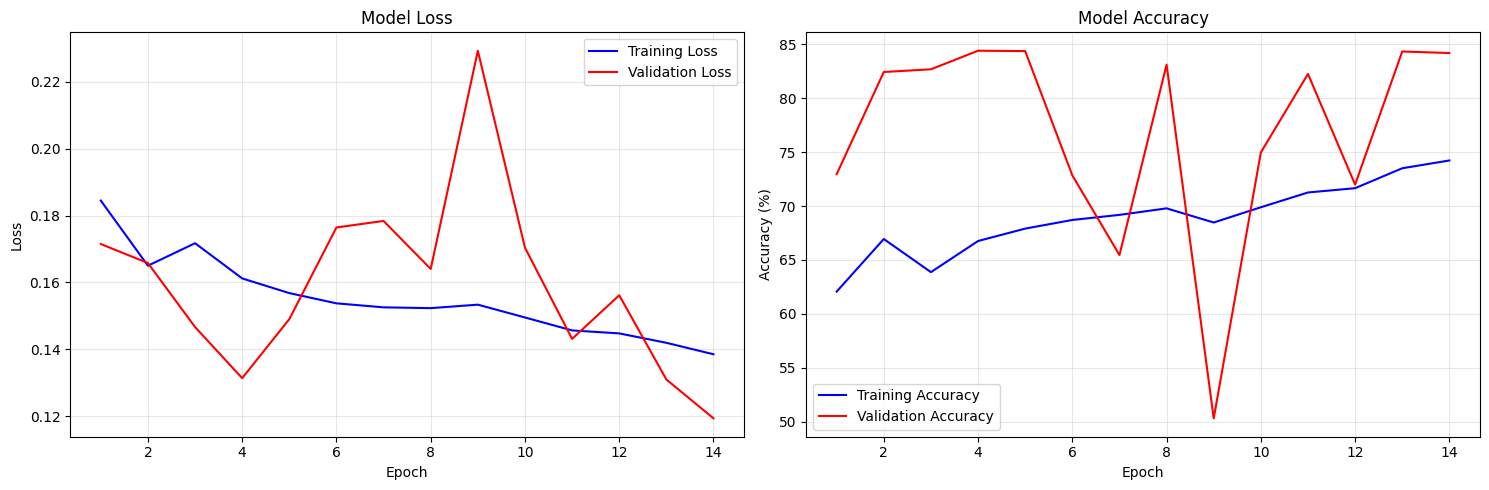

In [28]:
# Plot training history
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

## Model Evaluation

In [ ]:
# Load best model for evaluation (based on validation LOSS for parity)
print("Loading best model for evaluation (validation loss criterion)...")
try:
    checkpoint = torch.load('best_model_vit_full_focal.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Best model loaded (Epoch {checkpoint['epoch']})")
    print(f"  Best Validation Loss: {checkpoint['best_val_loss']:.4f}")
    print(f"  Best Validation Accuracy: {checkpoint['best_val_acc']:.2f}%")
except FileNotFoundError:
    print("❌ best_model_vit_full_focal.pth not found! Using current model state.")
except Exception as e:
    print(f"❌ Error loading best model: {e}")
    print("Using current model state.")

model.eval()
print("Model set to evaluation mode for testing.\n")

print("Evaluating ViT-B16 FULL MODEL on test set...")
print("📊 Model specifications:")
print("  • Model: MitosisClassifier (ViT-B16)")
print("  • Backbone: ViT-B16 (trainable)")
print("  • Patch size: 16x16")
print("  • Output: 2 neurons with SoftMax activation")
print("  • Loss function: FocalLoss()")
print(f"  • Device: {device}")
print("  • Classification head: 768 -> 512 -> 256 -> 128 -> 2")
print("  • Output format: [p(class0), p(class1)]")

# Reuse same criterion instance

test_running_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_targets = []
all_test_probs = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        test_running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

        all_test_preds.extend(predicted.cpu().numpy())
        all_test_targets.extend(target.cpu().numpy())
        all_test_probs.extend(output.cpu().numpy())

        if batch_idx % 10 == 0:
            current_acc = 100. * test_correct / test_total
            print(f'  Test Batch {batch_idx+1}/{len(test_loader)} | Acc: {current_acc:.2f}%')

test_loss = test_running_loss / len(test_loader)
test_acc = 100. * test_correct / test_total

print(f"\n📈 Test Results (ViT-B16 Full Model Training):")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")
print(f"  Total test samples: {test_total}")
print(f"  Correct predictions: {test_correct}")

# Store results
all_preds = all_test_preds
y_pred = np.array(all_test_preds)
y_true = np.array(all_test_targets)
y_probs = np.array(all_test_probs)
print("\n✅ Evaluation complete using best loss-based model (if available)")

Loading best model for evaluation...
✅ Best model loaded successfully!
  Epoch: 4
  Best Validation Accuracy: 84.40%
  Best Validation Loss: 0.1313
Model set to evaluation mode for testing.

Evaluating Vision Transformer ViT-B16 model on test set...
📊 Model specifications:
  • Model: MitosisClassifier
  • Backbone: Vision Transformer ViT-B16
  • Patch size: 16x16
  • Output: 2 neurons with SoftMax activation
  • Loss function: FocalLoss()
  • Device: cuda
  • Classification head: 768 -> 512 -> 256 -> 128 -> 2
  • Output layer: 2 neurons with Softmax activation
  • Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction
  Test Batch 1/88 | Acc: 90.62%
  Test Batch 11/88 | Acc: 82.95%
  Test Batch 21/88 | Acc: 83.93%
  Test Batch 31/88 | Acc: 84.58%
  Test Batch 41/88 | Acc: 84.53%
  Test Batch 51/88 | Acc: 84.50%
  Test Batch 61/88 | Acc: 84.58%
  Test Batch 71/88 | Acc: 83.98%
  Test Batch 81/88 | Acc: 84.18%

📈 Test Results (Vision Transformer ViT-B16 Best M

In [30]:
# Analyze performance by different factors
test_df_with_predictions = test_df.copy().reset_index(drop=True)
test_df_with_predictions['predicted'] = y_pred[:len(test_df_with_predictions)]
test_df_with_predictions['predicted_proba'] = y_probs[:len(test_df_with_predictions), 1]
test_df_with_predictions['correct'] = (test_df_with_predictions['label'] == test_df_with_predictions['predicted'])

print("Performance Analysis:")

# Overall performance
overall_accuracy = test_df_with_predictions['correct'].mean()
print(f"Overall Test Accuracy: {overall_accuracy:.4f} ({len(test_df_with_predictions)} samples)")

# Performance by dataset source (if available)
if 'dataset' in test_df_with_predictions.columns and len(test_df_with_predictions['dataset'].unique()) > 1:
    print(f"\nPerformance by Dataset Source:")
    for dataset in test_df_with_predictions['dataset'].unique():
        if pd.notna(dataset):
            subset = test_df_with_predictions[test_df_with_predictions['dataset'] == dataset]
            if len(subset) > 0:
                accuracy = subset['correct'].mean()
                print(f"  {dataset}: {accuracy:.4f} accuracy ({len(subset)} samples)")

# Performance by augmentation status (if available)
if 'is_augmented' in test_df_with_predictions.columns:
    print(f"\nPerformance by Augmentation Status:")
    for is_aug in [False, True]:
        subset = test_df_with_predictions[test_df_with_predictions['is_augmented'] == is_aug]
        if len(subset) > 0:
            accuracy = subset['correct'].mean()
            status = "Augmented" if is_aug else "Original"
            print(f"  {status}: {accuracy:.4f} accuracy ({len(subset)} samples)")

# Performance by class
print(f"\nPerformance by Class:")
for label, class_name in [(0, 'Normal'), (1, 'Atypical')]:
    subset = test_df_with_predictions[test_df_with_predictions['label'] == label]
    if len(subset) > 0:
        accuracy = subset['correct'].mean()
        print(f"  {class_name}: {accuracy:.4f} accuracy ({len(subset)} samples)")

# Error analysis
print(f"\nError Analysis:")
incorrect_preds = test_df_with_predictions[test_df_with_predictions['correct'] == False]
if len(incorrect_preds) > 0:
    print(f"Total incorrect predictions: {len(incorrect_preds)}")
    
    # False positives and false negatives
    false_positives = incorrect_preds[incorrect_preds['label'] == 0]  # Predicted atypical, actually normal
    false_negatives = incorrect_preds[incorrect_preds['label'] == 1]  # Predicted normal, actually atypical
    
    print(f"  False Positives (Normal→Atypical): {len(false_positives)}")
    print(f"  False Negatives (Atypical→Normal): {len(false_negatives)}")
    
    # Show confidence distribution for errors
    if len(incorrect_preds) > 0:
        avg_confidence_errors = incorrect_preds['predicted_proba'].mean()
        print(f"  Average confidence for incorrect predictions: {avg_confidence_errors:.3f}")
else:
    print("No incorrect predictions!")

# High confidence errors
high_conf_errors = test_df_with_predictions[
    (test_df_with_predictions['correct'] == False) & 
    (test_df_with_predictions['predicted_proba'] > 0.8)
]
if len(high_conf_errors) > 0:
    print(f"\nHigh-confidence errors (>0.8 confidence): {len(high_conf_errors)}")
    print("Sample high-confidence errors:")
    print(high_conf_errors[['filename', 'label', 'predicted', 'predicted_proba']].head())

Performance Analysis:
Overall Test Accuracy: 0.8440 (2788 samples)

Performance by Dataset Source:
  MIDOG25: 0.8530 accuracy (2402 samples)
  AMI-BR: 0.7876 accuracy (386 samples)

Performance by Augmentation Status:
  Original: 0.8440 accuracy (2788 samples)

Performance by Class:
  Normal: 1.0000 accuracy (2353 samples)
  Atypical: 0.0000 accuracy (435 samples)

Error Analysis:
Total incorrect predictions: 435
  False Positives (Normal→Atypical): 0
  False Negatives (Atypical→Normal): 435
  Average confidence for incorrect predictions: 0.317


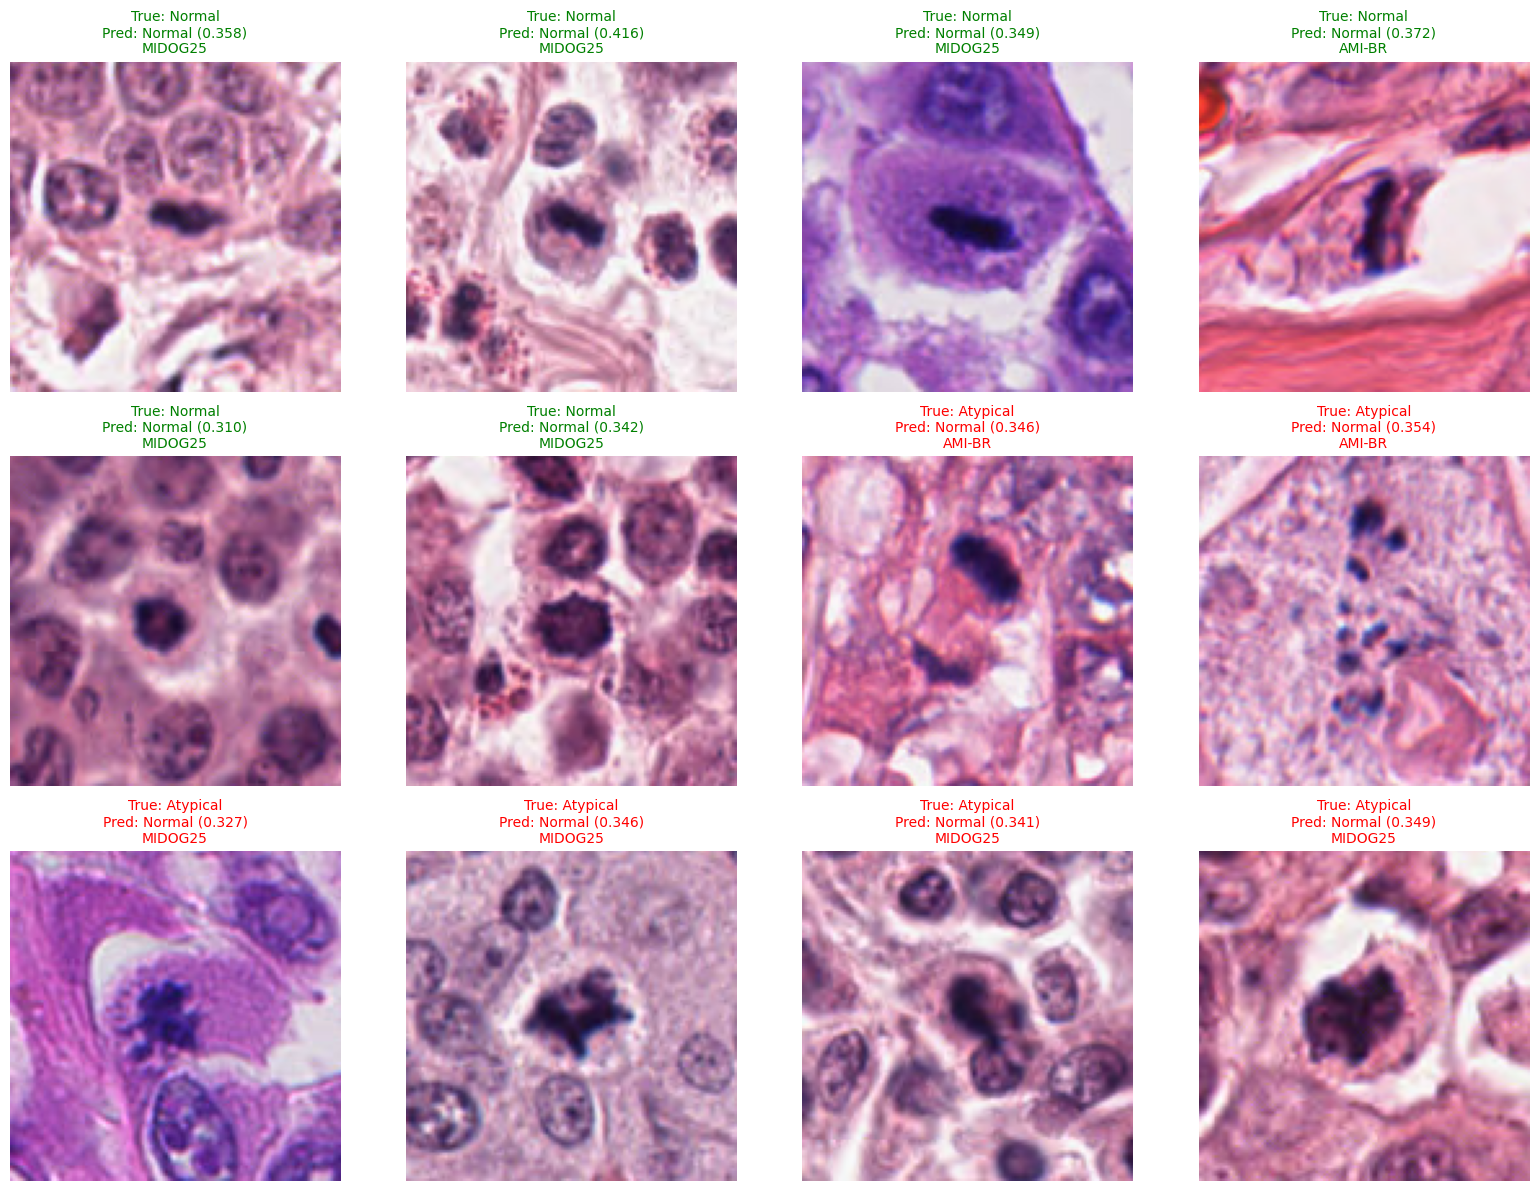

In [31]:
# Visualize some predictions
def visualize_predictions(df_with_pred, n_samples=12):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    # Get some correct and incorrect predictions
    correct_pred = df_with_pred[df_with_pred['correct'] == True]
    incorrect_pred = df_with_pred[df_with_pred['correct'] == False]
    
    if len(correct_pred) > 0:
        correct_sample = correct_pred.sample(min(6, len(correct_pred)))
    else:
        correct_sample = pd.DataFrame()
    
    if len(incorrect_pred) > 0:
        incorrect_sample = incorrect_pred.sample(min(6, len(incorrect_pred)))
    else:
        incorrect_sample = pd.DataFrame()
    
    samples = pd.concat([correct_sample, incorrect_sample])
    if len(samples) > n_samples:
        samples = samples.sample(n_samples)
    
    for i, (_, row) in enumerate(samples.iterrows()):
        if i >= n_samples:
            break
            
        try:
            img = Image.open(row['image_path'])
            axes[i].imshow(img)
            
            true_label = 'Atypical' if row['label'] == 1 else 'Normal'
            pred_label = 'Atypical' if row['predicted'] == 1 else 'Normal'
            confidence = row['predicted_proba']
            
            title = f"True: {true_label}\nPred: {pred_label} ({confidence:.3f})\n{row['dataset']}"
            color = 'green' if row['correct'] else 'red'
            axes[i].set_title(title, color=color, fontsize=10)
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{row['filename']}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(samples), n_samples):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(test_df_with_predictions)

## Model Saving and Summary (Parity with ConvNeXt Pipeline)
The following cell saves:
- Final full-model checkpoint (state dict + optimizer + config)
- JSON metrics summary containing: architecture, parameters, splits, focal loss settings, best validation metrics, test metrics, class distribution

It mirrors the structure used in the ConvNeXt notebook so downstream analysis scripts can treat both models uniformly.

In [ ]:
# Save the final model & results summary (ConvNeXt parity)
import json
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

print("Saving final ViT-B16 full model artifact & metrics summary...")

# Compute metrics
test_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
try:
    auc_score = roc_auc_score(y_true, y_probs[:, 1]) if len(np.unique(y_true)) > 1 else 0.0
except Exception as e:
    print(f"⚠️ AUC calculation error: {e}")
    auc_score = 0.0

# Dataset composition
total_samples = len(df)
original_samples = len(df[df['is_augmented'] == False]) if 'is_augmented' in df.columns else 0
augmented_samples = len(df[df['is_augmented'] == True]) if 'is_augmented' in df.columns else 0

# Parameter counts (reuse previously computed)
results_summary = {
    'model_architecture': 'ViT-B16 + Custom Head (Full Model)',
    'framework': 'PyTorch',
    'backbone_model': 'ViT-B16',
    'pretrained_weights': 'ImageNet (automatic)',
    'training_approach': 'Full model training (entire network)',
    'class_balancing': 'Focal Loss + WeightedRandomSampler',
    'learning_rate': float(LEARNING_RATE),
    'output_format': '2 neurons with Softmax activation',
    'loss_function': 'Focal Loss',
    'focal_alpha': float(alpha_focal),
    'focal_gamma': 2.0,
    'classification_head': '768 -> 512 -> 256 -> 128 -> 2',
    'prediction_method': 'argmax of [p(class0), p(class1)]',
    'dataset_source': 'Pre-augmented Kaggle dataset',
    'total_samples': int(total_samples),
    'original_samples': int(original_samples),
    'augmented_samples': int(augmented_samples),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'test_samples': len(test_df),
    'test_accuracy': float(test_acc / 100),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'auc_score': float(auc_score),
    'best_val_accuracy': float(best_val_acc / 100),
    'best_val_loss': float(best_val_loss),
    'early_stopping_metric': 'validation_loss',
    'early_stopping_patience': PATIENCE,
    'class_distribution': df['label'].value_counts().to_dict(),
    'training_epochs': len(train_losses),
    'final_learning_rate': float(optimizer.param_groups[0]['lr']),
    'used_augmented_data': augmented_samples > 0,
    'trainable_parameters': int(trainable_params),
    'total_parameters': int(total_params),
    'trainable_percentage': float(trainable_params/total_params*100),
    'full_model_training': True,
    'advanced_loss': True,
}

# Save checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
    'best_val_acc': best_val_acc,
    'model_config': {
        'model_name': 'vit_base_patch16_224',
        'num_classes': NUM_CLASSES,
        'img_size': IMG_SIZE,
        'patch_size': 16,
        'output_activation': 'Softmax',
        'loss_function': 'Focal Loss',
        'focal_alpha': alpha_focal,
        'focal_gamma': 2.0,
        'architecture': 'ViT-B16 -> GAP -> 768 -> 512 -> 256 -> 128 -> 2',
        'training_approach': 'Full model training',
        'class_balancing': 'Focal Loss + WeightedRandomSampler',
        'learning_rate': LEARNING_RATE,
        'backbone_trainable': True,
        'pretrained_source': 'ImageNet'
    }
}, 'mitotic_figure_vit_b16_full_focal_classifier.pth')

with open('vit_b16_full_focal_training_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Model saved as 'mitotic_figure_vit_b16_full_focal_classifier.pth'")
print("Results saved to 'vit_b16_full_focal_training_results.json'")

print("\n================== FINAL RESULTS SUMMARY - ViT-B16 FULL MODEL + FOCAL LOSS ==================")
print(f"Model: {results_summary['backbone_model']}")
print(f"Classification head: {results_summary['classification_head']}")
print(f"Loss: Focal Loss (alpha={results_summary['focal_alpha']:.3f}, gamma={results_summary['focal_gamma']})")
print(f"Trainable Parameters: {results_summary['trainable_parameters']:,} / {results_summary['total_parameters']:,} ({results_summary['trainable_percentage']:.1f}%)")
print(f"Best Val Loss: {results_summary['best_val_loss']:.4f} | Best Val Acc: {results_summary['best_val_accuracy']:.4f}")
print(f"Test Accuracy: {results_summary['test_accuracy']:.4f} | F1: {results_summary['test_f1']:.4f} | AUC: {results_summary['auc_score']:.4f}")
print("===========================================================================================")

Model saved as 'mitotic_figure_vit_b16_focal_gap_classifier.pth'
AUC Score calculated: 0.5741


In [ ]:
# OPTIONAL: Package artifacts (Kaggle style). Comment out if running locally.
# !zip -r ViT_FullModel_Focal.zip /kaggle/working
# from IPython.display import FileLink
# FileLink('ViT_FullModel_Focal.zip')
print("Artifact packaging step (zip) is commented out for local environment safety.")

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/mitotic_figure_vit_b16_focal_gap_classifier.pth (deflated 7%)
  adding: kaggle/working/best_model_vit_focal_gap.pth (deflated 7%)
mv: 'ViT.zip' and '/kaggle/working/ViT.zip' are the same file


In [35]:
from IPython.display import FileLink
FileLink('ViT.zip')

/kaggle/working/ViT.zip

In [ ]:
# !rm -rf /kaggle/working/*


In [ ]:
# Quick Smoke Test (1 batch dry run) - Optional
# Runs a single forward/backward pass to ensure everything is wired correctly before long training.

def smoke_test(model, loader, device):
    model.train()
    data_iter = iter(loader)
    data, target = next(data_iter)
    data, target = data.to(device), target.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = FocalLoss(alpha=1.0, gamma=2.0)
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    print(f"Smoke test batch size: {data.size(0)}, loss: {loss.item():.4f}")

# Uncomment to run once before training (if you restart the kernel)
# smoke_test(model, train_loader, device)